In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))
from dotenv import load_dotenv
import seaborn as sns
import pandas as pd
import numpy as np

from db import PostgresDB
from schemas import Proband

In [13]:
load_dotenv()


True

In [14]:
db = PostgresDB(
    db_name=os.getenv("DB_NAME"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    user=os.getenv("DB_USER"),
)


Connected to database


In [15]:
ICU_SCHEMA = "mimiciv_icu"
HOSP_SCHEMA = "mimiciv_hosp"
ED_SCHEMA = "mimiciv_ed"


In [16]:
def create_sepsis_cohort(db: PostgresDB):
    probands = []
    query = """
        SELECT sep.subject_id, sep.stay_id, sta.hadm_id
        FROM mimiciv_derived.sepsis3 sep, mimiciv_icu.icustays sta
        WHERE sep.stay_id = sta.stay_id limit 100;
    """
    db_result = db.execute_query(query)
    for subject_id, stay_id, hadm_id in db_result:
        probands.append(
            Proband(subject_id=subject_id, stay_id=stay_id, hadm_id=hadm_id)
        )
    cohort = Cohort(participants=probands)
    return cohort


In [17]:
from cohorts import Cohort, Proband
from labevents import LabEvent, LabEventComparator

sepsis_query = """
    SELECT sep.subject_id, sta.hadm_id
    FROM mimiciv_derived.sepsis3 sep, mimiciv_icu.icustays sta
    WHERE sep.stay_id = sta.stay_id limit 100;
"""

kdigo_query = """
    SELECT DISTINCT kdigo.subject_id, sta.hadm_id
    FROM mimiciv_derived.kdigo_stages kdigo, mimiciv_icu.icustays sta
    WHERE kdigo.stay_id = sta.stay_id AND kdigo.aki_stage > 2 LIMIT 100;
"""

meld_query = """
    SELECT meld.subject_id, sta.hadm_id
    FROM mimiciv_derived.meld meld, mimiciv_icu.icustays sta
    WHERE meld.stay_id = sta.stay_id AND meld.meld > 32
    ORDER BY RAndOM()
    LIMIT 100;
"""

cardiac_query = """
    SELECT card.subject_id, card.hadm_id
    FROM mimiciv_derived.cardiac_marker card
    WHERE card.hadm_id IS NOT NULL AND card.ntprobnp > 500 LIMIT 100;
"""


In [18]:
COUNT_PER_GROUP = 20

sepsis_pats = db.execute_query(sepsis_query)
meld_pats = db.execute_query(meld_query)
kdigo_pats = db.execute_query(kdigo_query)
card_pats = db.execute_query(cardiac_query)

groups = [meld_pats, card_pats]

participants = []
for group in groups:
    count = 0
    for pat in group:
        if pat[0] not in [p.subject_id for p in participants] and pat[1] not in [
            p.hadm_id for p in participants
        ]:
            participants.append(Proband(subject_id=pat[0], hadm_id=pat[1]))
            count += 1
        if count == COUNT_PER_GROUP:
            break


In [19]:
cohort = Cohort(participants=participants, db=db)

In [20]:
cohort.initialize_data(with_tfidf_diagnoses=True)
result = cohort.compare_encounters(aggregate_method="mean")

Finished encounter 22987108
Finished encounter 23676183
Finished encounter 24173031
Finished encounter 21027282
Finished encounter 21133938
Finished encounter 22205327
Finished encounter 20755971
Finished encounter 23095285
Finished encounter 29235759
Finished encounter 21240921
Finished encounter 28236354
Finished encounter 29234056
Finished encounter 21564201
Finished encounter 25098957
Finished encounter 21253864
Finished encounter 28570546
Finished encounter 21981172
Finished encounter 20518100
Finished encounter 26452361
Finished encounter 28605901
Finished encounter 24041886
Finished encounter 27363105
Finished encounter 20628437
Finished encounter 29161792
Finished encounter 25560295
Finished encounter 21493941
Finished encounter 28369146
Finished encounter 26828497
Finished encounter 23825247
Finished encounter 27445919
Finished encounter 22188171
Finished encounter 27389035
Finished encounter 24632331
Finished encounter 29709801
Finished encounter 25489255
Finished encounter 2

In [21]:
columne_names = [p.hadm_id for p in cohort.participants]
data = [e["similarity"] for e in result]
data = np.array(data).reshape(len(columne_names), len(columne_names))
df = pd.DataFrame(data=data, columns=columne_names, index=columne_names)

In [22]:
df.shape

(40, 40)

<Axes: >

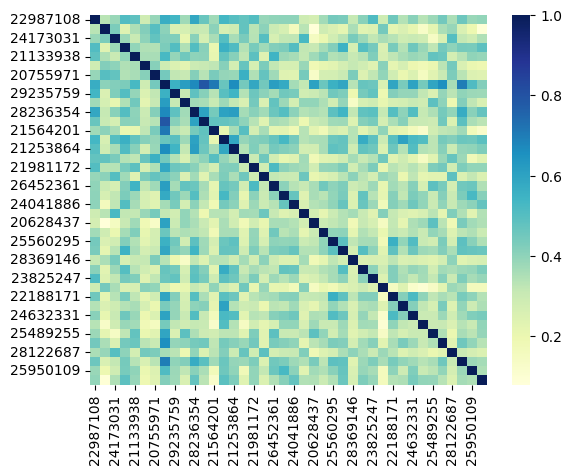

In [23]:
sns.heatmap(df, cmap="YlGnBu", fmt=".2f")

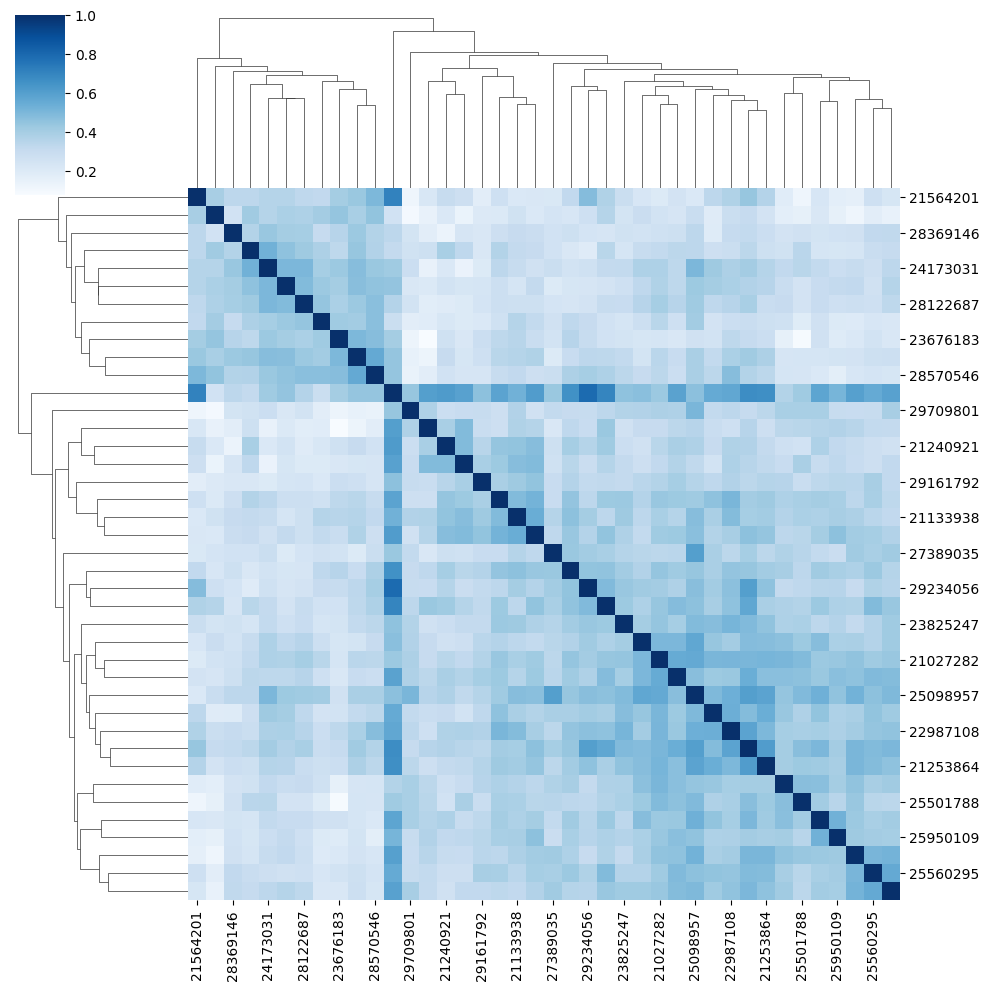

In [24]:
sns.clustermap(df, annot=False, fmt=".2f", cmap="Blues")

In [25]:
from sklearn.manifold import MDS

In [26]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation

In [27]:
meld_encounters = [e[1] for e in meld_pats]
sepsis_encounters = [e[1] for e in sepsis_pats]
kdigo_pats = [e[1] for e in kdigo_pats]
card_pats = [e[1] for e in card_pats]

In [28]:
spectral_cluster = SpectralClustering(n_clusters=2, affinity="precomputed", n_init=100).fit(df)
agglomerative_cluster = AgglomerativeClustering(n_clusters=2, affinity="precomputed", linkage="average").fit(df)
kmeans_cluster = KMeans(n_clusters=2, random_state=0).fit(df)
dbscan_cluster = DBSCAN(eps=0.5, min_samples=2).fit(df)
affinity_cluster = AffinityPropagation().fit(df)

/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
for cluster in [spectral_cluster, agglomerative_cluster, kmeans_cluster, dbscan_cluster, affinity_cluster]:
    print(f"Cluster: {cluster.__class__.__name__}")
    print("------------------")
    for index, group in enumerate(groups):
        print(cluster.labels_[index * COUNT_PER_GROUP: (index + 1) * COUNT_PER_GROUP])
    print("\n")

Cluster: SpectralClustering
------------------
[1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1]
[1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1]


Cluster: AgglomerativeClustering
------------------
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Cluster: KMeans
------------------
[1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1]
[1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1]


Cluster: DBSCAN
------------------
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


Cluster: AffinityPropagation
------------------
[2 3 0 1 4 3 3 2 1 6 2 2 3 1 2 3 4 0 4 1]
[1 0 6 4 5 1 0 1 1 3 5 5 5 5 6 4 0 2 4 1]




/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/tillrostalski/Git/simpa/venv/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<Axes: >

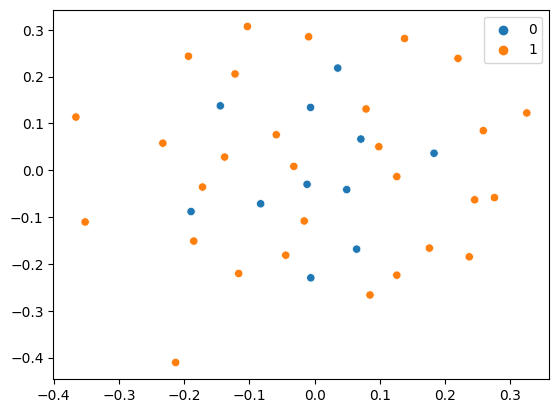

In [30]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(df)
sns.scatterplot(x=pos[:, 0], y=pos[:, 1], hue=kmeans_cluster.labels_, cmap="Set1")

In [31]:
right = 0
wrong = 0
for i, c in enumerate(cluster):
    if columne_names[i] in meld_encounters and c == 1:
        right += 1
    elif columne_names[i] in sepsis_encounters and c == 0:
        right += 1
    else:
        wrong += 1
print(f"right: {right}, wrong: {wrong}")

TypeError: 'AffinityPropagation' object is not iterable